In [1]:
from pathlib import Path
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep 
hep.style.use(hep.style.ATLAS)
# plt.style.use(hep.style.ATLAS)
import awkward as ak
from tqdm import tqdm 

import joblib
import vector
import numba as nb
# import ROOT

In [2]:
ssWW_Ntuple_folder_path = Path("/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/")
fit_input_folder_path = Path("/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/information_Run2_ssWWHpp/fit_inputs/")

# Prepare

In [88]:
Mjj_bin_edges = np.array([ 500.,  850., 1450., 2100., 2550., 3000.], dtype=float)
MT_bin_edges = np.array([0, 100, 180, 230, 280, 350, 500, 800, 1500], dtype=float)

mass_points1 = np.linspace(200, 550, int((550 - 200) / 25 + 1), dtype=int)
mass_points2 = np.linspace(600, 1000, int((1000 - 600) / 100 + 1), dtype=int)
mass_points3 = np.array([1500, 2000, 3000], dtype=int)
mass_points = np.concatenate([mass_points1, mass_points2, mass_points3])

period_labels = np.array(['a', 'd', 'e'])
dsid_map = dict.fromkeys(mass_points)
dsid_start = 511727 
for mass_idx, masss_point in enumerate(mass_points):
    dsid_map[masss_point] = dsid_start + mass_idx

ttree_prefix = 'HWWTree_'
ttree_channels = ['em', 'me', 'ee', 'mm']

## Signal

In [3]:
sorted(ssWW_Ntuple_folder_path.iterdir())

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_WZ'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Wgamma'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_ZZ'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_Zgamma'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/background_fakes'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/data'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGH7'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/signal_LOMGPy8')]

In [13]:
higgspp_folder_path = ssWW_Ntuple_folder_path / "higgspp"
sorted(higgspp_folder_path.iterdir())

[PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511727_full_run2_sig_X_mc16a_EWK_GM_H5_m200.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511727_full_run2_sig_X_mc16d_EWK_GM_H5_m200.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511727_full_run2_sig_X_mc16e_EWK_GM_H5_m200.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511728_full_run2_sig_X_mc16a_EWK_GM_H5_m225.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511728_full_run2_sig_X_mc16d_EWK_GM_H5_m225.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511728_full_run2_sig_X_mc16e_EWK_GM_H5_m225.root'),
 PosixPath('/global/cfs/projectdirs/atlas/hrzhao/sample/ssWWWZ_run3/ntuples_ssWW_230420/higgspp/511729_full_run2

In [9]:
## For the root files at different mass points, convert it to a pandas dataframe and save it as a pickle file
## Need to store some additional event information, like the period, channel etc 

In [89]:
higgspp = []
for mass_point in tqdm(mass_points):

    for period_label in period_labels:
        sig_m_period_path = higgspp_folder_path / f"{dsid_map[mass_point]}_full_run2_sig_X_mc16{period_label}_EWK_GM_H5_m{mass_point}.root"
        # print(sig_m_path.name)
        sig_m_period = uproot.open(sig_m_period_path) if sig_m_period_path.exists() else print(f"{sig_m_period_path} does not exist")
        for ttree_channel in ttree_channels:
            ttree_name = ttree_prefix + ttree_channel
            df_sig_m_period_channel = sig_m_period[ttree_name].arrays(library="pd")
            # change the unit of mjj from MeV to GeV 
            # df_sig_m_period_channel['mjj'] = df_sig_m_period_channel['mjj'] / 1000
            # add a new column to store the mass point
            df_sig_m_period_channel['file_identifer'] = f"signal_m{mass_point}"
            # add a new column to store the period label
            df_sig_m_period_channel['period_label'] = period_label
            # add a new column to store the channel
            df_sig_m_period_channel['channel'] = ttree_channel
            # add a new column to store the dsid
            # df_sig_m_period_channel['dsid'] = dsid_map[mass_point]

            higgspp.append(df_sig_m_period_channel)

assert len(higgspp) == len(mass_points) * len(period_labels) * len(ttree_channels)
df_higgspp = pd.concat(higgspp, ignore_index=True)

100%|██████████| 23/23 [00:30<00:00,  1.31s/it]


In [90]:
lep0_4vec = vector.array({
    "px": df_higgspp["lep0_px"],
    "py": df_higgspp["lep0_py"],
    "pz": df_higgspp["lep0_pz"],
    "E": df_higgspp["lep0_e"],
})

lep1_4vec = vector.array({
    "px": df_higgspp["lep1_px"],
    "py": df_higgspp["lep1_py"],
    "pz": df_higgspp["lep1_pz"],
    "E": df_higgspp["lep1_e"],
})

In [91]:
df_higgspp['lep0_eta'] = lep0_4vec.eta
df_higgspp['lep1_eta'] = lep1_4vec.eta

df_higgspp['lep0_phi'] = lep0_4vec.phi
df_higgspp['lep1_phi'] = lep1_4vec.phi

df_higgspp['target'] = 1 

In [92]:
df_higgspp.head()

,runNumber,eventNumber,mjj,dyjj,met,lep0_pt,lep1_pt,jet0_pt,jet1_pt,lep0_px,...,chFlipWeight,weight,file_identifer,period_label,channel,lep0_eta,lep1_eta,lep0_phi,lep1_phi,target
0,284500,14601,801949.875,5.100585,64270.414062,78535.625000,47092.480469,72193.867188,54515.601562,-13771.283203,...,0.999986,0.067403,signal_m200,a,em,0.685348,1.591141,-1.747058,2.768547,1
1,284500,10422,1446468.125,5.512991,105120.257812,48329.632812,44830.546875,101798.164062,81047.179688,-46049.464844,...,1.000005,0.050500,signal_m200,a,em,0.678817,-0.691944,-2.833193,-1.621876,1
2,284500,14653,700154.750,4.318008,76280.273438,71677.265625,32477.414062,81508.117188,76487.039062,63227.390625,...,0.999986,0.059568,signal_m200,a,em,0.628099,1.639016,0.490469,-1.340614,1
3,284500,10882,528562.000,3.172592,77275.921875,61421.968750,30469.593750,170441.562500,63760.125000,30813.949219,...,0.999923,0.056380,signal_m200,a,em,0.930431,1.964278,-1.045261,2.749825,1
4,284500,14464,2339444.250,6.622375,54202.949219,66543.000000,27943.820312,145741.781250,49700.605469,64896.824219,...,0.999923,0.057285,signal_m200,a,em,-0.883232,-0.640482,0.222896,3.137925,1


In [93]:
df_higgspp.columns

Index(['runNumber', 'eventNumber', 'mjj', 'dyjj', 'met', 'lep0_pt', 'lep1_pt',
       'jet0_pt', 'jet1_pt', 'lep0_px', 'lep0_py', 'lep0_pz', 'lep0_e',
       'lep1_px', 'lep1_py', 'lep1_pz', 'lep1_e', 'nJets', 'MCweight',
       'muonIsoWeight', 'muonTTVAWeight', 'muonRecoWeight',
       'electronIsoWeight', 'electronRecoWeight', 'electronIDWeight',
       'jvtWeight', 'forwardJVTWeight', 'prwWeight', 'eventWeight',
       'triggerWeight', 'bTagWeight', 'chFlipWeight', 'weight',
       'file_identifer', 'period_label', 'channel', 'lep0_eta', 'lep1_eta',
       'lep0_phi', 'lep1_phi', 'target'],
      dtype='object')

In [94]:
joblib.dump(df_higgspp, "signal.pkl")

['signal.pkl']

In [48]:
!ls -alh

total 65M
drwxrws--x+ 2 hrzhao atlas 4.0K May 17 09:52 .
drwxrws--x+ 6 hrzhao atlas 4.0K May 11 12:21 ..
-rw-rw----+ 1 hrzhao atlas 235K May 16 11:54 explore_WW.ipynb
-rw-rw----+ 1 hrzhao atlas  29K May 17 10:03 NNtraining.ipynb
-rw-rw----+ 1 hrzhao atlas 3.5K May 15 11:24 prefityieldshpp.txt
-rw-rw----+ 1 hrzhao atlas  65M May 17 10:04 signal.pkl


## Background

In [50]:
WZ = sorted(ssWW_Ntuple_folder_path.iterdir())[0]

In [52]:
test_file = sorted(WZ.iterdir())[0]

In [53]:
test_file = uproot.open(test_file)

In [55]:
test_file['HWWTree_em'].keys()

['runNumber',
 'eventNumber',
 'mjj',
 'dyjj',
 'met',
 'lep0_pt',
 'lep1_pt',
 'jet0_pt',
 'jet1_pt',
 'lep0_px',
 'lep0_py',
 'lep0_pz',
 'lep0_e',
 'lep1_px',
 'lep1_py',
 'lep1_pz',
 'lep1_e',
 'nJets',
 'MCweight',
 'muonIsoWeight',
 'muonTTVAWeight',
 'muonRecoWeight',
 'electronIsoWeight',
 'electronRecoWeight',
 'electronIDWeight',
 'jvtWeight',
 'forwardJVTWeight',
 'prwWeight',
 'eventWeight',
 'triggerWeight',
 'bTagWeight',
 'chFlipWeight',
 'weight']

In [83]:
files_not_use = ["background_run2_MGH7EG_WZEW", "background_run2_MGPy8EG_WZINT", "background_run2_MGPy8_Zgamma", "background_run2_MGPy8_Wgamma"]
files_not_use = files_not_use + ["signal_run2_500986_LOMGPy8_EW", "signal_run2_500988_LOMGPy8_INT", "signal_run2_500987_LOMGPy8_QCD"]
bkg = []

for folder_path in ssWW_Ntuple_folder_path.iterdir():
    if folder_path.name == 'higgspp':
        continue

    for file_path in folder_path.glob("*.root"):
        if not (file_path.name.startswith("background_run2") or file_path.name.startswith("signal_run2")):
            continue
        
        if file_path.stem in files_not_use:
            continue

        print(file_path.name)

        bkg_period = uproot.open(file_path) if file_path.exists() else print(f"{file_path} does not exist")
        for ttree_channel in ttree_channels:
            ttree_name = ttree_prefix + ttree_channel
            df_bkg_period = bkg_period[ttree_name].arrays(library="pd")

            df_bkg_period['file_identifer'] = file_path.stem
            # add a new column to store the period label
            df_bkg_period['period_label'] = "run2"
            # add a new column to store the channel
            df_bkg_period['channel'] = ttree_channel

            bkg.append(df_bkg_period)

df_bkg = pd.concat(bkg, ignore_index=True)

background_run2_SHERPA_ZZ.root
background_run2_MGPy8EG_WZEW.root
background_run2_SHERPA222_WZQCD.root
signal_run2_500989_LOMGH7_EW.root
signal_run2_500991_LOMGH7_INT.root
signal_run2_500990_LOMGH7_QCD.root
background_run2_SHERPA2211_Zgamma.root
background_run2_SHERPA2211_Wgamma.root
background_run2_ddFakes.root


In [95]:
bkg_lep0_4vec = vector.array({
    "px": df_bkg["lep0_px"],
    "py": df_bkg["lep0_py"],
    "pz": df_bkg["lep0_pz"],
    "E": df_bkg["lep0_e"],
})

bkg_lep1_4vec = vector.array({
    "px": df_bkg["lep1_px"],
    "py": df_bkg["lep1_py"],
    "pz": df_bkg["lep1_pz"],
    "E": df_bkg["lep1_e"],
})

df_bkg['lep0_eta'] = bkg_lep0_4vec.eta
df_bkg['lep1_eta'] = bkg_lep1_4vec.eta

df_bkg['lep0_phi'] = bkg_lep0_4vec.phi
df_bkg['lep1_phi'] = bkg_lep1_4vec.phi

df_bkg['target'] = 0 


In [96]:
df_bkg.groupby('file_identifer').sum(numeric_only=True)

,runNumber,eventNumber,mjj,dyjj,met,lep0_pt,lep1_pt,jet0_pt,jet1_pt,lep0_px,...,eventWeight,triggerWeight,bTagWeight,chFlipWeight,weight,lep0_eta,lep1_eta,lep0_phi,lep1_phi,target
file_identifer,,,,,,,,,,,,,,,,,,,,,
background_run2_MGPy8EG_WZEW,2485765000,6253146485,1.084079e+10,35462.757812,8.265911e+08,9.649669e+08,4.776067e+08,1.737782e+09,9.201450e+08,1041387.5,...,2.923141e-02,8196.129883,8243.820312,8273.436523,14.951426,-68.882057,-152.092178,6.251157,84.253258,0
background_run2_SHERPA2211_Wgamma,165680000,27050765103,5.412646e+08,1935.693604,8.262498e+07,1.149059e+08,4.063242e+07,1.719130e+08,6.087071e+07,-13723854.0,...,2.186996e+08,549.046509,546.977966,552.036316,9.693901,-8.617013,-11.923738,4.629329,0.308621,0
background_run2_SHERPA2211_Zgamma,6958000,375020159,1.915157e+07,83.481361,4.335998e+07,4.483438e+07,1.554741e+06,5.979138e+06,2.140765e+06,28871934.0,...,2.851310e+06,22.847031,22.743439,23.000000,0.556548,3.948245,4.950361,12.238044,3.763445,0
background_run2_SHERPA222_WZQCD,8354367000,1059734991797,2.574598e+10,102617.906250,2.795189e+09,3.254775e+09,1.573630e+09,6.007457e+09,2.976359e+09,28296180.0,...,3.402357e+03,27563.935547,27608.953125,27800.986328,82.753011,55.193386,133.418655,190.668839,-539.267944,0
background_run2_SHERPA_ZZ,863636500,105641968738,2.816705e+09,11271.513672,2.070341e+08,2.775048e+08,1.422203e+08,5.262961e+08,3.072145e+08,4150881.5,...,1.329020e+04,2859.726807,2864.567871,2880.015869,2.509481,-85.018509,3.021948,-66.613640,41.213062,0
background_run2_ddFakes,72673947,340175056071,2.166709e+08,885.117859,2.168893e+07,2.429885e+07,1.062523e+07,3.759302e+07,2.136892e+07,2595215.0,...,2.170000e+02,217.000000,217.000000,217.000000,66.252239,-19.661736,-19.955822,-25.413239,0.903293,0
signal_run2_500989_LOMGH7_EW,60505043500,401609254807,2.903436e+11,872342.687500,2.314249e+10,2.487352e+10,1.227435e+10,4.526428e+10,2.394904e+10,47639444.0,...,6.879555e+03,198930.593750,200121.250000,201508.437500,234.902752,-376.073975,-15.108148,-315.601257,-540.710815,0
signal_run2_500990_LOMGH7_QCD,7614174500,50279964426,2.276992e+10,81682.093750,3.099220e+09,3.103691e+09,1.495290e+09,6.464312e+09,3.431518e+09,-5923694.5,...,6.844889e+02,25123.675781,25091.558594,25375.912109,24.049193,-21.855574,5.406155,71.473213,213.134354,0
signal_run2_500991_LOMGH7_INT,23962657000,158813430041,8.261957e+10,266582.125000,1.022674e+10,1.042733e+10,5.032350e+09,2.180388e+10,1.158541e+10,13860665.0,...,2.230506e+02,78792.421875,78941.492188,79814.390625,7.572280,165.412628,-295.984406,752.990356,629.716248,0


In [98]:
df_bkg.head()

,runNumber,eventNumber,mjj,dyjj,met,lep0_pt,lep1_pt,jet0_pt,jet1_pt,lep0_px,...,chFlipWeight,weight,file_identifer,period_label,channel,lep0_eta,lep1_eta,lep0_phi,lep1_phi,target
0,284500,3978202,8.132535e+05,3.426486,58833.875000,69981.968750,53140.550781,146455.890625,138819.687500,51203.800781,...,1.000117,0.000629,background_run2_SHERPA_ZZ,run2,em,1.990464,1.718411,-0.750026,1.507005,0
1,284500,4156341,1.754824e+06,4.406075,82061.265625,37708.855469,33957.457031,247015.828125,147645.343750,-26557.912109,...,1.000060,0.000876,background_run2_SHERPA_ZZ,run2,em,2.292020,1.348897,-2.352217,1.442176,0
2,284500,3585202,1.721305e+06,3.130399,94584.710938,69996.156250,42288.261719,490617.968750,241905.625000,-39856.824219,...,1.000117,0.000660,background_run2_SHERPA_ZZ,run2,em,-1.835316,1.770463,2.176590,2.264817,0
3,284500,5259986,9.122511e+05,5.029059,69000.054688,34057.214844,31802.187500,78706.437500,67876.468750,-27417.648438,...,1.000060,0.004939,background_run2_SHERPA_ZZ,run2,em,-1.914827,-0.988383,2.506551,-0.434667,0
4,284500,5810559,7.922457e+05,4.783946,70476.507812,60201.320312,28479.134766,95677.351562,53974.089844,57599.632812,...,0.999744,0.000410,background_run2_SHERPA_ZZ,run2,em,-2.427609,-1.934541,-0.295064,2.510034,0


In [99]:
joblib.dump(df_bkg, "bkg.pkl")

['bkg.pkl']

In [100]:
!ls -alh

total 117M
drwxrws--x+ 2 hrzhao atlas 4.0K May 17 10:32 .
drwxrws--x+ 6 hrzhao atlas 4.0K May 11 12:21 ..
-rw-rw----+ 1 hrzhao atlas  57M May 17 10:32 bkg.pkl
-rw-rw----+ 1 hrzhao atlas 235K May 16 11:54 explore_WW.ipynb
-rw-rw----+ 1 hrzhao atlas  50K May 17 10:30 NNtraining.ipynb
-rw-rw----+ 1 hrzhao atlas 3.5K May 15 11:24 prefityieldshpp.txt
-rw-rw----+ 1 hrzhao atlas  61M May 17 10:31 signal.pkl


# Distribution

In [2]:
df_signal = joblib.load("signal.pkl")
df_bkg = joblib.load("bkg.pkl") 

In [3]:
df_bkg

,runNumber,eventNumber,mjj,dyjj,met,lep0_pt,lep1_pt,jet0_pt,jet1_pt,lep0_px,...,chFlipWeight,weight,file_identifer,period_label,channel,lep0_eta,lep1_eta,lep0_phi,lep1_phi,target
0,284500,3978202,8.132535e+05,3.426486,58833.875000,69981.968750,53140.550781,146455.890625,138819.687500,51203.800781,...,1.000117,0.000629,background_run2_SHERPA_ZZ,run2,em,1.990464,1.718411,-0.750026,1.507005,0
1,284500,4156341,1.754824e+06,4.406075,82061.265625,37708.855469,33957.457031,247015.828125,147645.343750,-26557.912109,...,1.000060,0.000876,background_run2_SHERPA_ZZ,run2,em,2.292020,1.348897,-2.352217,1.442176,0
2,284500,3585202,1.721305e+06,3.130399,94584.710938,69996.156250,42288.261719,490617.968750,241905.625000,-39856.824219,...,1.000117,0.000660,background_run2_SHERPA_ZZ,run2,em,-1.835316,1.770463,2.176590,2.264817,0
3,284500,5259986,9.122511e+05,5.029059,69000.054688,34057.214844,31802.187500,78706.437500,67876.468750,-27417.648438,...,1.000060,0.004939,background_run2_SHERPA_ZZ,run2,em,-1.914827,-0.988383,2.506551,-0.434667,0
4,284500,5810559,7.922457e+05,4.783946,70476.507812,60201.320312,28479.134766,95677.351562,53974.089844,57599.632812,...,0.999744,0.000410,background_run2_SHERPA_ZZ,run2,em,-2.427609,-1.934541,-0.295064,2.510034,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346408,362204,2024724852,5.418361e+05,3.332590,31763.699219,60304.500000,39033.945312,106594.281250,92441.843750,41219.769531,...,1.000000,0.235159,background_run2_ddFakes,run2,mm,0.950126,-1.407653,-0.818212,0.143464,0
346409,362204,1711804174,6.298018e+05,2.514359,61295.082031,242468.000000,71575.210938,173070.078125,157387.609375,-98431.953125,...,1.000000,0.370490,background_run2_ddFakes,run2,mm,1.877565,-1.599339,1.988824,-0.661518,0
346410,362297,1464100036,1.158549e+06,5.589394,88100.882812,48077.121094,46412.679688,117275.289062,42263.488281,26993.039062,...,1.000000,0.235159,background_run2_ddFakes,run2,mm,0.565462,1.029433,-0.974656,2.736566,0
346411,363400,949733567,5.117224e+05,3.909964,61455.574219,66593.921875,42565.207031,81932.062500,60663.843750,32470.925781,...,1.000000,0.235159,background_run2_ddFakes,run2,mm,2.310123,-2.484005,1.061462,-2.214136,0


In [4]:
df_signal.columns

Index(['runNumber', 'eventNumber', 'mjj', 'dyjj', 'met', 'lep0_pt', 'lep1_pt',
       'jet0_pt', 'jet1_pt', 'lep0_px', 'lep0_py', 'lep0_pz', 'lep0_e',
       'lep1_px', 'lep1_py', 'lep1_pz', 'lep1_e', 'nJets', 'MCweight',
       'muonIsoWeight', 'muonTTVAWeight', 'muonRecoWeight',
       'electronIsoWeight', 'electronRecoWeight', 'electronIDWeight',
       'jvtWeight', 'forwardJVTWeight', 'prwWeight', 'eventWeight',
       'triggerWeight', 'bTagWeight', 'chFlipWeight', 'weight',
       'file_identifer', 'period_label', 'channel', 'lep0_eta', 'lep1_eta',
       'lep0_phi', 'lep1_phi', 'target'],
      dtype='object')

In [6]:
features = df_signal.columns[2:18].tolist() + df_signal.columns[-5:-1].tolist() 

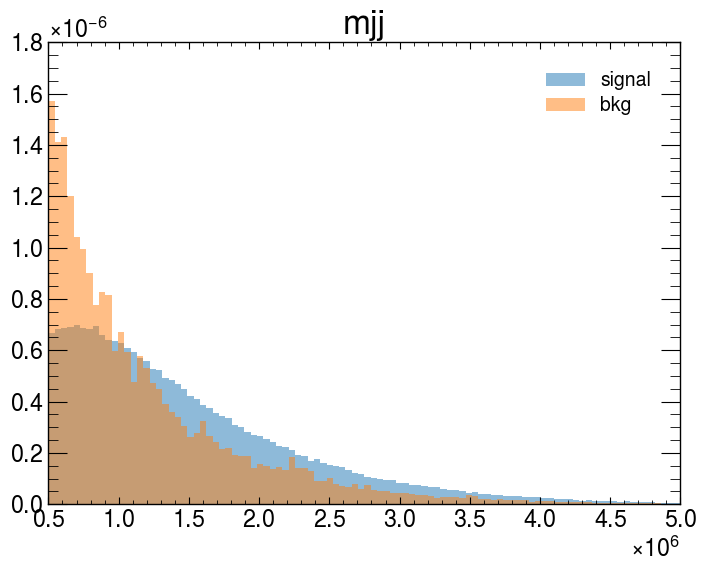

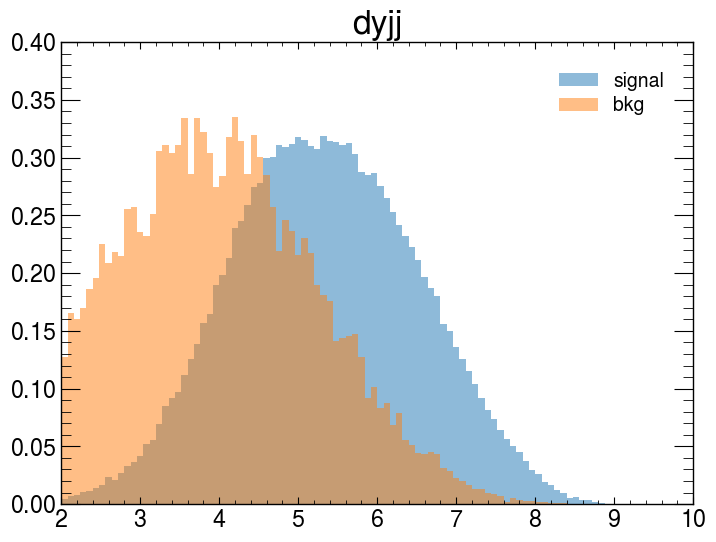

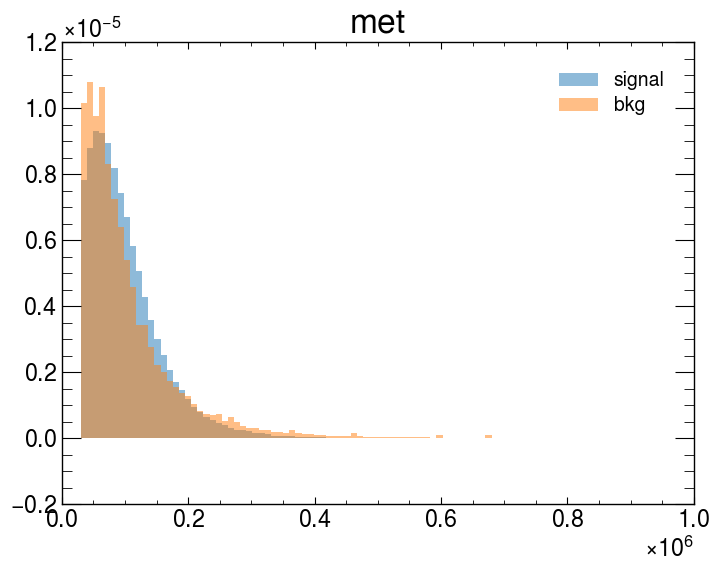

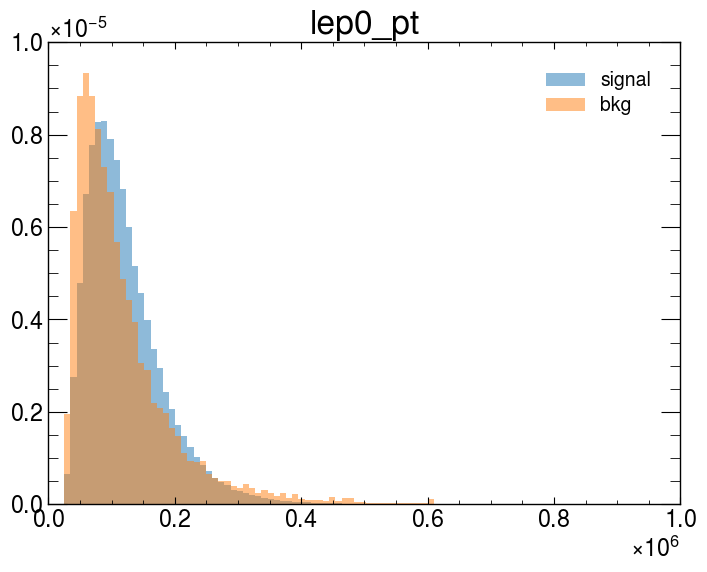

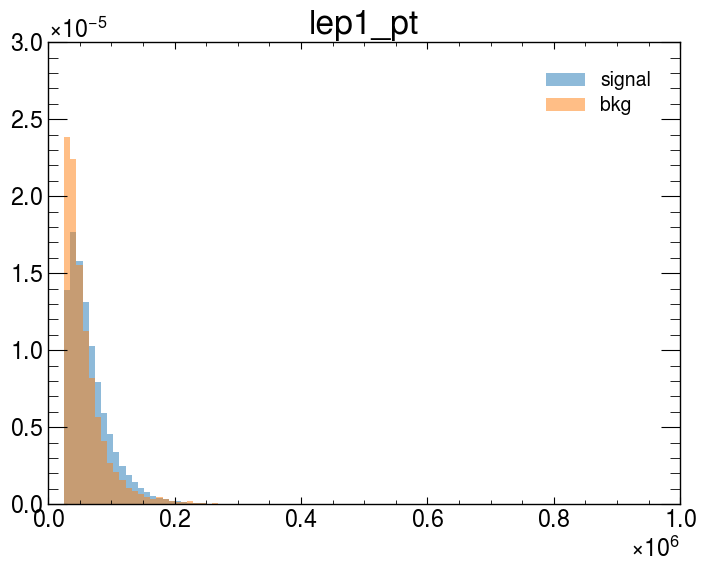

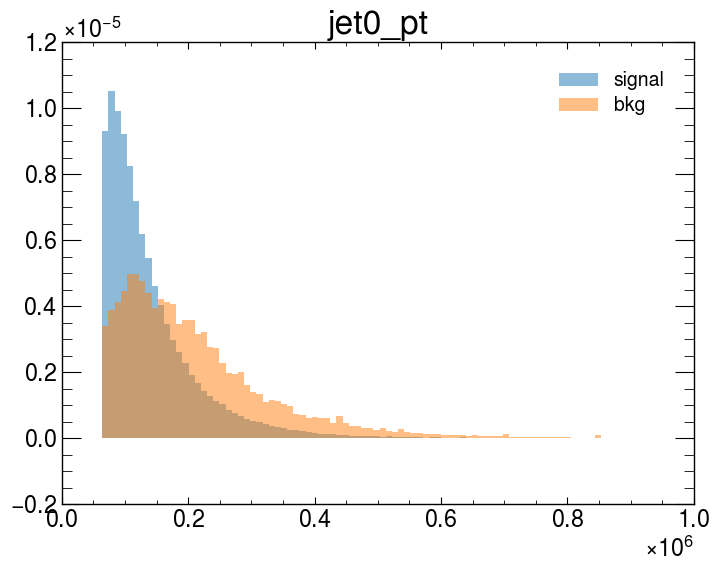

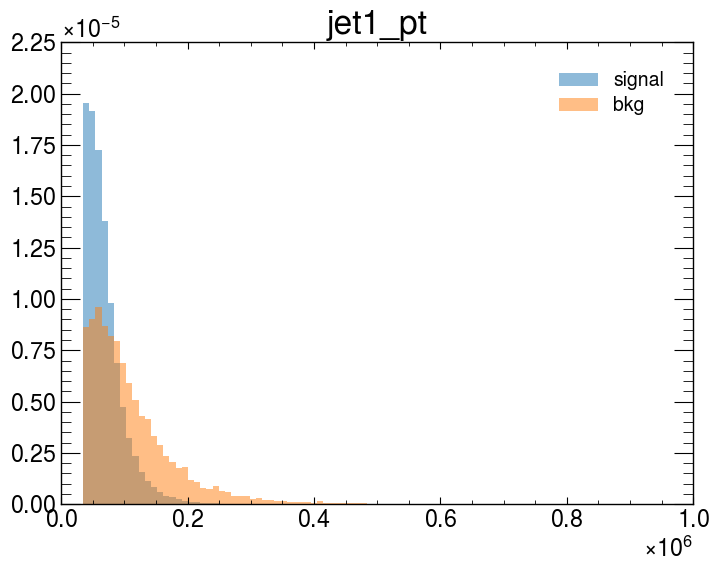

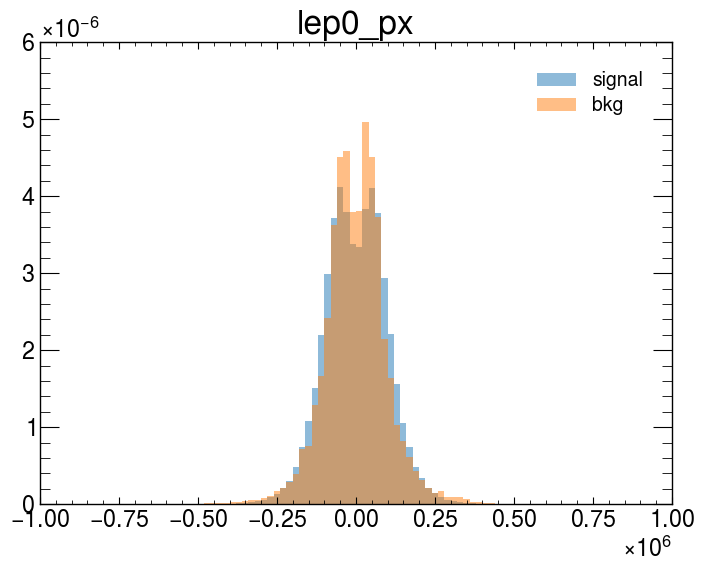

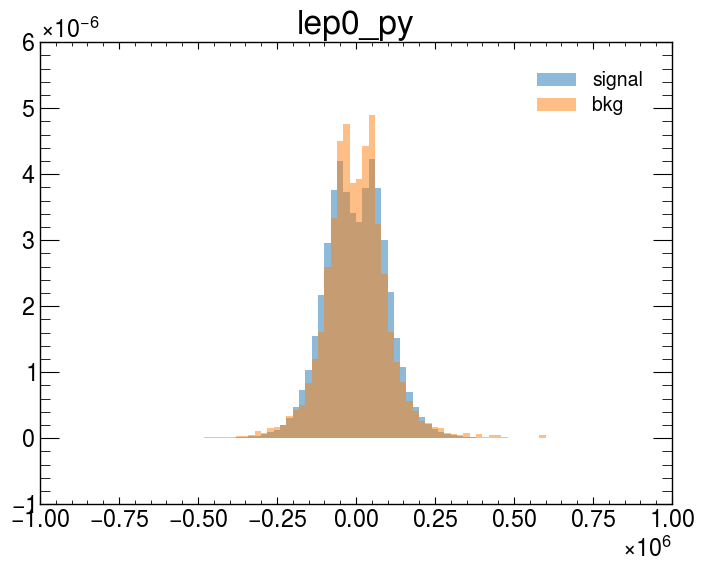

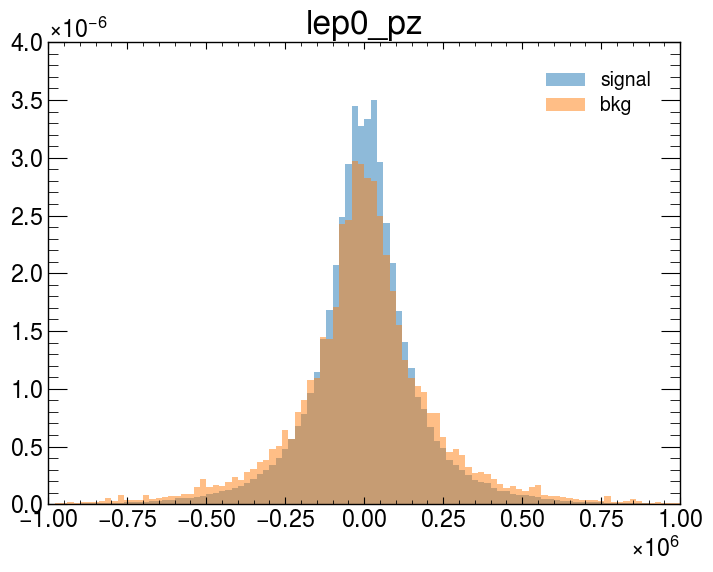

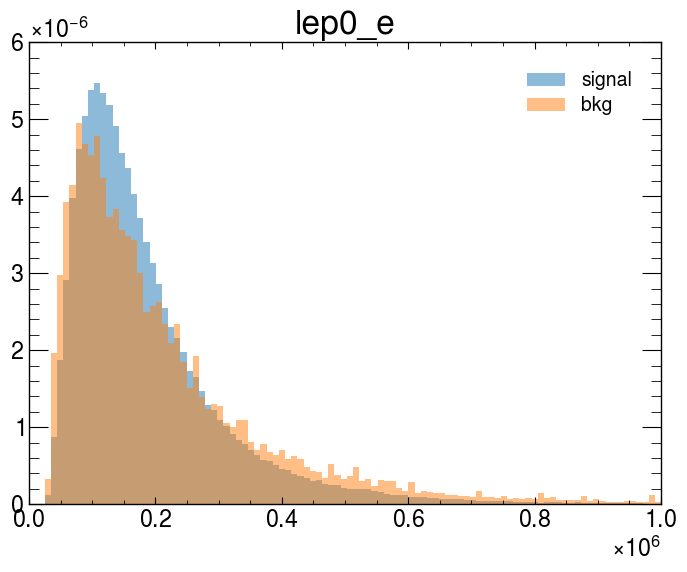

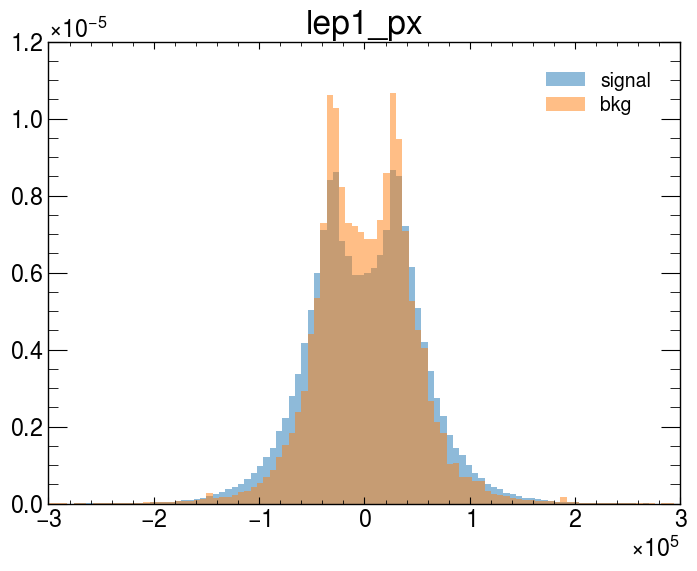

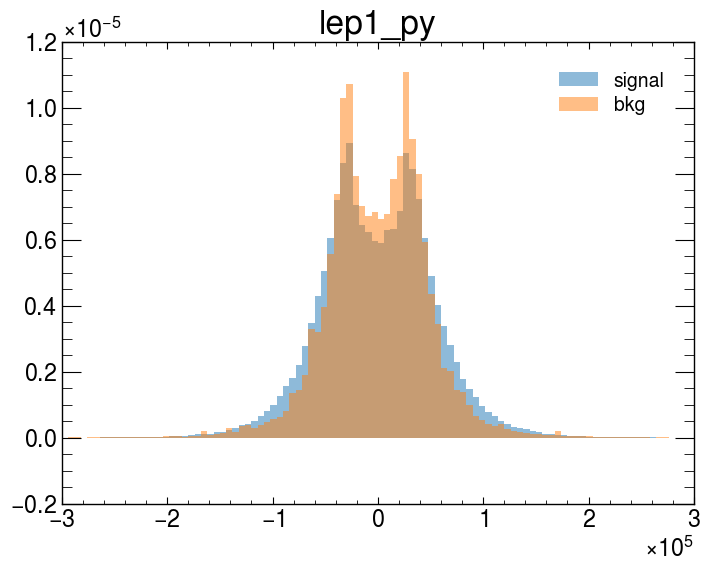

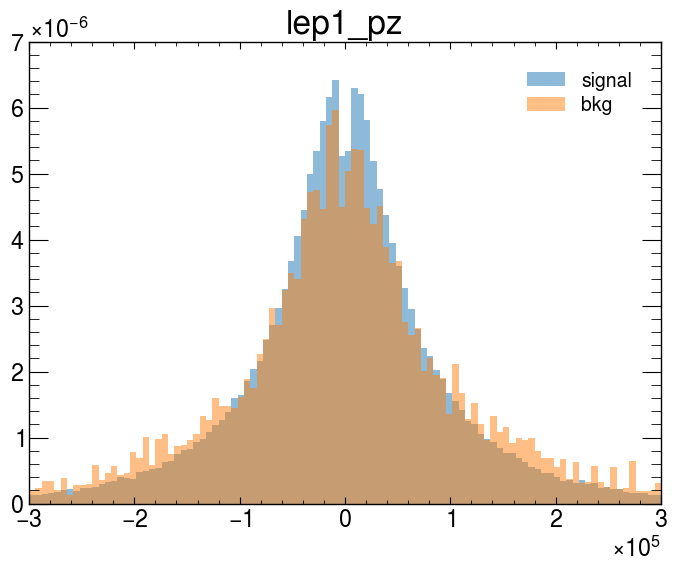

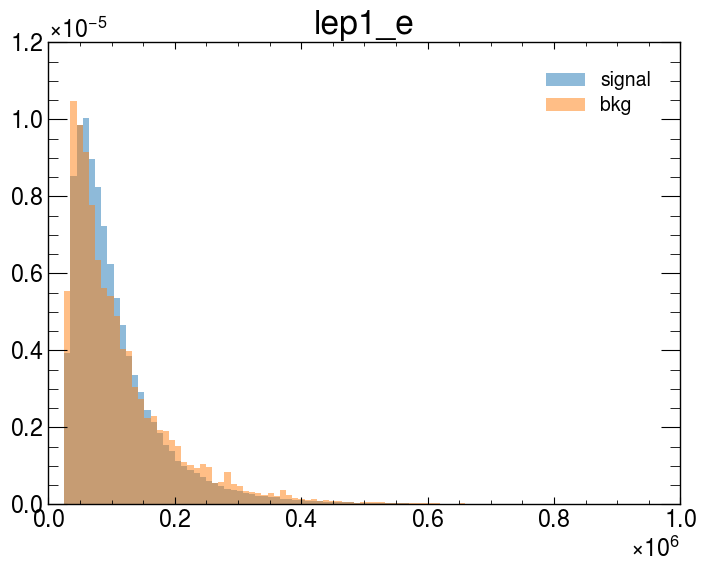

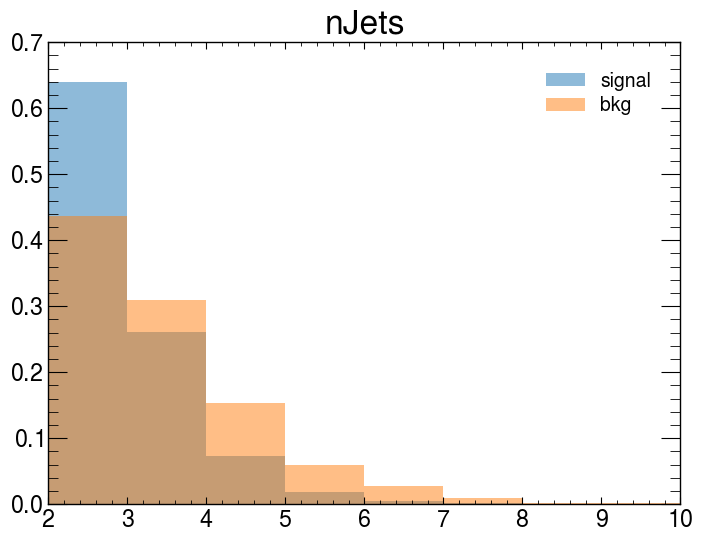

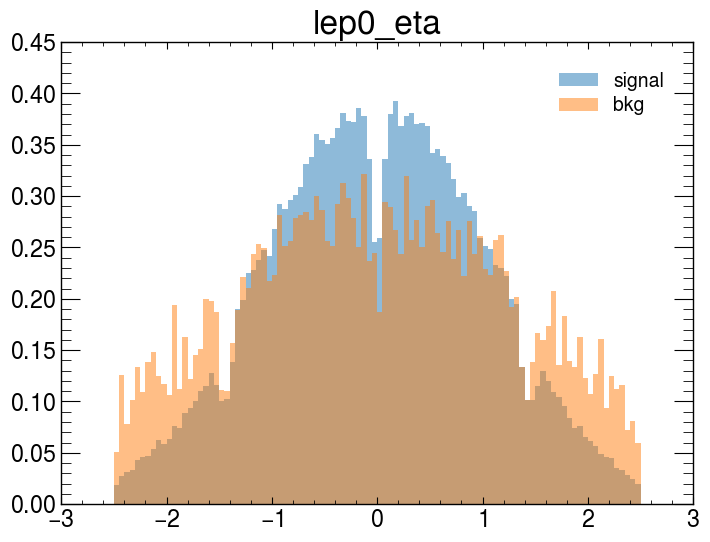

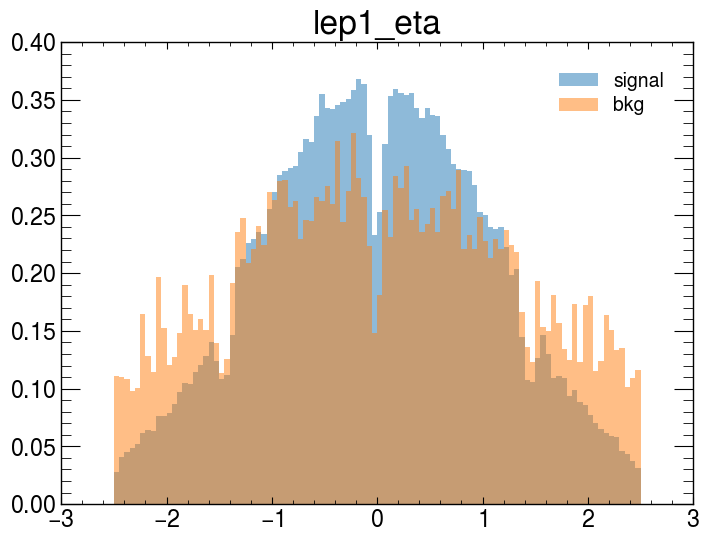

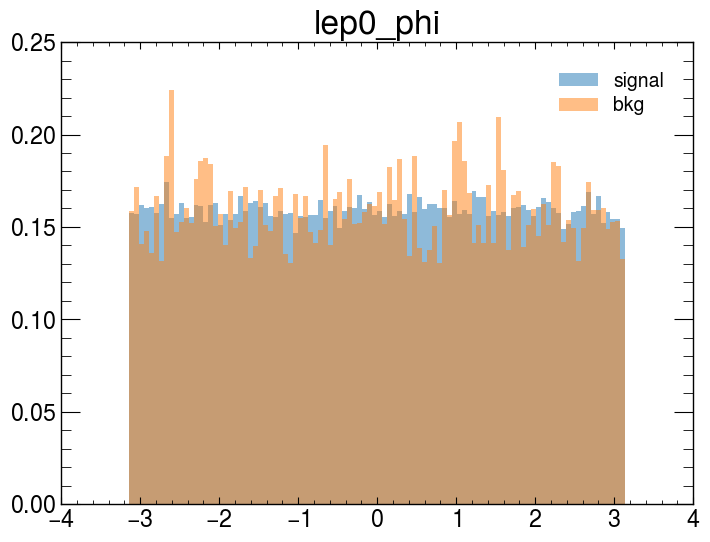

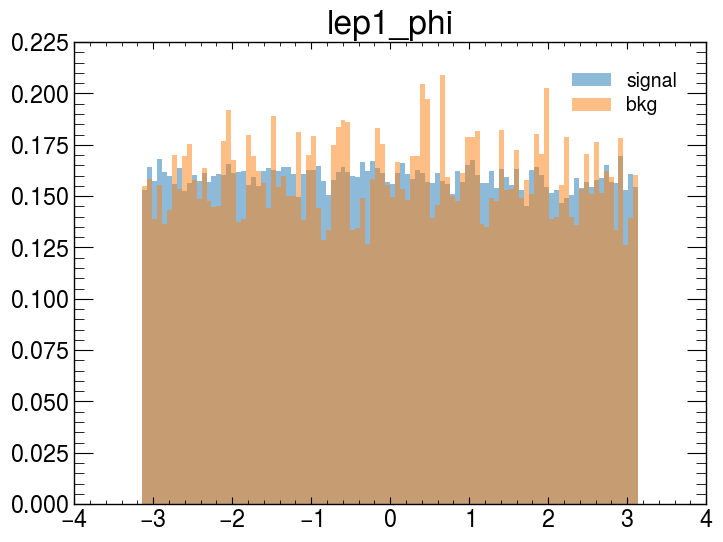

In [7]:
bin_edges_maps = {
    "mjj": np.linspace(500*1e3, 5000*1e3, 101),
    "dyjj": np.linspace(2, 10, 101),
    "met": np.linspace(30*1e3, 1000*1e3, 101),
    "lep0_pt": np.linspace(25*1e3, 1*1e6, 101),
    "lep1_pt": np.linspace(25*1e3, 1*1e6, 101),
    "jet0_pt": np.linspace(25*1e3, 1*1e6, 101),
    "jet1_pt": np.linspace(25*1e3, 1*1e6, 101),
    "lep0_px": np.linspace(-1*1e6, 1*1e6, 101),
    "lep0_py": np.linspace(-1*1e6, 1*1e6, 101),
    "lep0_pz": np.linspace(-1*1e6, 1*1e6, 101),
    "lep0_e": np.linspace(25*1e3, 1*1e6, 101),
    "lep1_px": np.linspace(-0.3*1e6, 0.3*1e6, 101),
    "lep1_py": np.linspace(-0.3*1e6, 0.3*1e6, 101),
    "lep1_pz": np.linspace(-0.3*1e6, 0.3*1e6, 101),
    "lep1_e": np.linspace(25*1e3, 1*1e6, 101),
    "nJets": np.linspace(2, 10, 9),
    "lep0_eta": np.linspace(-2.5, 2.5, 101),
    "lep1_eta": np.linspace(-2.5, 2.5, 101),
    "lep0_phi": np.linspace(-np.pi, np.pi, 101),
    "lep1_phi": np.linspace(-np.pi, np.pi, 101),
}

for feature in features:
    bin_edge = bin_edges_maps[feature]
    fig, ax = plt.subplots()
    ax.hist(df_signal[feature], bins=bin_edge, weights=df_signal["weight"], density = True, label="signal", alpha=0.5)
    ax.hist(df_bkg[feature], bins=bin_edge, weights=df_bkg["weight"], density = True, label="bkg", alpha=0.5)
    ax.legend()
    ax.set_title(feature)
    plt.show()
    

# Sample Stats

In [99]:
# df_signal = df_signal.loc[df_signal['weight'] > 0]
# df_bkg = df_bkg.loc[df_bkg['weight'] > 0]

In [100]:
len(df_bkg)

319137

In [101]:
len(df_signal)

358772

In [102]:
df_bkg['weight'].sum()

460.47714321547693

In [103]:
# contains 23 mass points 
df_signal['weight'].sum() 

4152.295878309949

In [13]:
df_signal_sum = df_signal.groupby('file_identifer').sum(numeric_only=True)

In [15]:
df_signal_sum['weight']

file_identifer
signal_m1000     11.107396
signal_m1500      3.076995
signal_m200     316.204417
signal_m2000      0.909824
signal_m225     348.174002
signal_m250     310.083783
signal_m275     326.299250
signal_m300     290.561009
signal_m3000      0.351672
signal_m325     304.074156
signal_m350     264.864532
signal_m375     260.025123
signal_m400     235.164044
signal_m425     230.446559
signal_m450     206.154965
signal_m475     200.828744
signal_m500     181.414278
signal_m525     170.223347
signal_m550     156.776465
signal_m600     136.074981
signal_m700     101.805028
signal_m800      77.256619
signal_m900      14.503084
Name: weight, dtype: float64

In [16]:
df_signal.groupby('file_identifer').sum(numeric_only=True)['weight'] / np.sqrt(df_bkg['weight'].sum())

file_identifer
signal_m1000     0.527585
signal_m1500     0.146153
signal_m200     15.019243
signal_m2000     0.043215
signal_m225     16.537751
signal_m250     14.728522
signal_m275     15.498733
signal_m300     13.801219
signal_m3000     0.016704
signal_m325     14.443074
signal_m350     12.580675
signal_m375     12.350810
signal_m400     11.169945
signal_m425     10.945872
signal_m450      9.792057
signal_m475      9.539069
signal_m500      8.616911
signal_m525      8.085358
signal_m550      7.446651
signal_m600      6.463361
signal_m700      4.835589
signal_m800      3.669575
signal_m900      0.688875
Name: weight, dtype: float64

In [19]:
df_signal.groupby('file_identifer').count()

,runNumber,eventNumber,mjj,dyjj,met,lep0_pt,lep1_pt,jet0_pt,jet1_pt,lep0_px,...,bTagWeight,chFlipWeight,weight,period_label,channel,lep0_eta,lep1_eta,lep0_phi,lep1_phi,target
file_identifer,,,,,,,,,,,,,,,,,,,,,
signal_m1000,22392,22392,22392,22392,22392,22392,22392,22392,22392,22392,...,22392,22392,22392,22392,22392,22392,22392,22392,22392,22392
signal_m1500,22993,22993,22993,22993,22993,22993,22993,22993,22993,22993,...,22993,22993,22993,22993,22993,22993,22993,22993,22993,22993
signal_m200,6125,6125,6125,6125,6125,6125,6125,6125,6125,6125,...,6125,6125,6125,6125,6125,6125,6125,6125,6125,6125
signal_m2000,22257,22257,22257,22257,22257,22257,22257,22257,22257,22257,...,22257,22257,22257,22257,22257,22257,22257,22257,22257,22257
signal_m225,7333,7333,7333,7333,7333,7333,7333,7333,7333,7333,...,7333,7333,7333,7333,7333,7333,7333,7333,7333,7333
signal_m250,8502,8502,8502,8502,8502,8502,8502,8502,8502,8502,...,8502,8502,8502,8502,8502,8502,8502,8502,8502,8502
signal_m275,9673,9673,9673,9673,9673,9673,9673,9673,9673,9673,...,9673,9673,9673,9673,9673,9673,9673,9673,9673,9673
signal_m300,10613,10613,10613,10613,10613,10613,10613,10613,10613,10613,...,10613,10613,10613,10613,10613,10613,10613,10613,10613,10613
signal_m3000,20217,20217,20217,20217,20217,20217,20217,20217,20217,20217,...,20217,20217,20217,20217,20217,20217,20217,20217,20217,20217


In [22]:
df_bkg.groupby('file_identifer').sum()['weight']

/tmp/ipykernel_198862/189659772.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bkg.groupby('file_identifer').sum()['weight']


file_identifer
background_run2_MGPy8EG_WZEW          14.951426
background_run2_SHERPA2211_Wgamma      9.693901
background_run2_SHERPA2211_Zgamma      0.556548
background_run2_SHERPA222_WZQCD       82.753011
background_run2_SHERPA_ZZ              2.509481
background_run2_ddFakes               66.252239
signal_run2_500989_LOMGH7_EW         234.902752
signal_run2_500990_LOMGH7_QCD         24.049193
signal_run2_500991_LOMGH7_INT          7.572280
Name: weight, dtype: float64

# Training Scheme 1 

Here all mass points are used, i.e. VBF events vs various bkgs.   

In [7]:
features

['mjj',
 'dyjj',
 'met',
 'lep0_pt',
 'lep1_pt',
 'jet0_pt',
 'jet1_pt',
 'lep0_px',
 'lep0_py',
 'lep0_pz',
 'lep0_e',
 'lep1_px',
 'lep1_py',
 'lep1_pz',
 'lep1_e',
 'nJets',
 'lep0_eta',
 'lep1_eta',
 'lep0_phi',
 'lep1_phi']

In [8]:
n_samples = 300000
sig_features = df_signal.sample(n_samples, random_state=42)
bkg_features = df_bkg.sample(n_samples, random_state=42) 
X = pd.concat([sig_features, bkg_features])
y = np.concatenate([np.ones(n_samples), np.zeros(n_samples)])

In [9]:
from sklearn.model_selection import train_test_split
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.1, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.1/0.9 ,random_state=42)

In [10]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [11]:
bdt = GradientBoostingClassifier(n_estimators = 100, random_state = 42, verbose=1, validation_fraction=0.1/0.9, n_iter_no_change=10, tol=0.01)
bdt.fit(X_dev[features], y_dev)

      Iter       Train Loss   Remaining Time 
         1           1.3165            6.96m
         2           1.2576            6.89m
         3           1.2086            6.82m
         4           1.1665            6.75m
         5           1.1300            6.68m
         6           1.0987            6.62m
         7           1.0712            6.55m
         8           1.0473            6.48m
         9           1.0260            6.41m
        10           1.0072            6.35m
        20           0.8925            5.64m
        30           0.8418            4.95m
        40           0.8160            4.24m
        50           0.8005            3.54m
        60           0.7903            2.84m


GradientBoostingClassifier(n_iter_no_change=10, random_state=42, tol=0.01,
                           validation_fraction=0.11111111111111112, verbose=1)

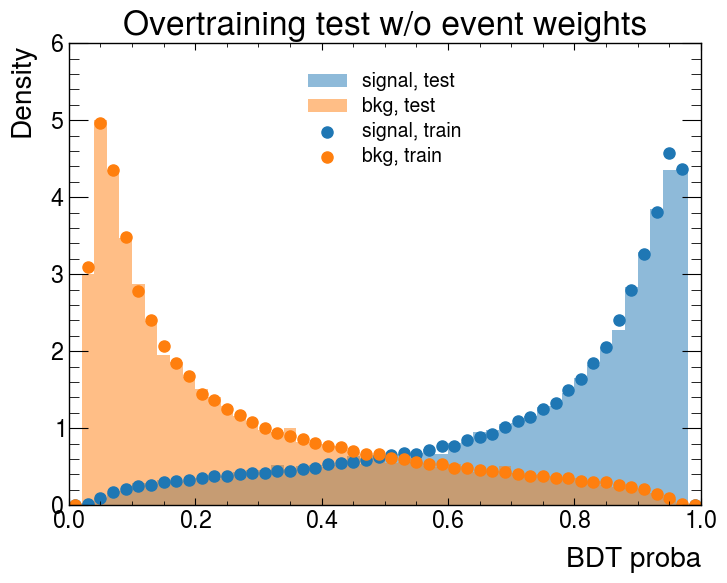

In [196]:
y_test_proba = bdt.predict_proba(X_test[features])[:, 1]
y_train_proba = bdt.predict_proba(X_train[features])[:, 1] 

bin_edges_proba = np.linspace(0, 1, 51)
bin_centers_proba = (bin_edges_proba[1:] + bin_edges_proba[:-1]) / 2

fig, ax = plt.subplots()
ax.hist(y_test_proba[y_test==1], bins=bin_edges_proba, density=True, label="signal, test", alpha=0.5)
ax.hist(y_test_proba[y_test==0], bins=bin_edges_proba, density=True, label="bkg, test", alpha=0.5)

# ax.hist(y_train_proba[y_train==1], bins=bin_edges_proba, density=True, label="train, signal", alpha=0.5)
# ax.hist(y_train_proba[y_train==0], bins=bin_edges_proba, density=True, label="train, bkg", alpha=0.5)


y_train_sig_bin_contents, _ = np.histogram(y_train_proba[y_train==1], bins=bin_edges_proba, density=True)
y_train_bkg_bin_contents, _ = np.histogram(y_train_proba[y_train==0], bins=bin_edges_proba, density=True)

ax.scatter(bin_centers_proba, y_train_sig_bin_contents, label="signal, train")
ax.scatter(bin_centers_proba, y_train_bkg_bin_contents, label="bkg, train")

ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Density")
ax.set_title("Overtraining test w/o event weights")
plt.show()

## Unweighted 

In [ ]:
y_test_proba = bdt.predict_proba(X_test[features])[:, 1]

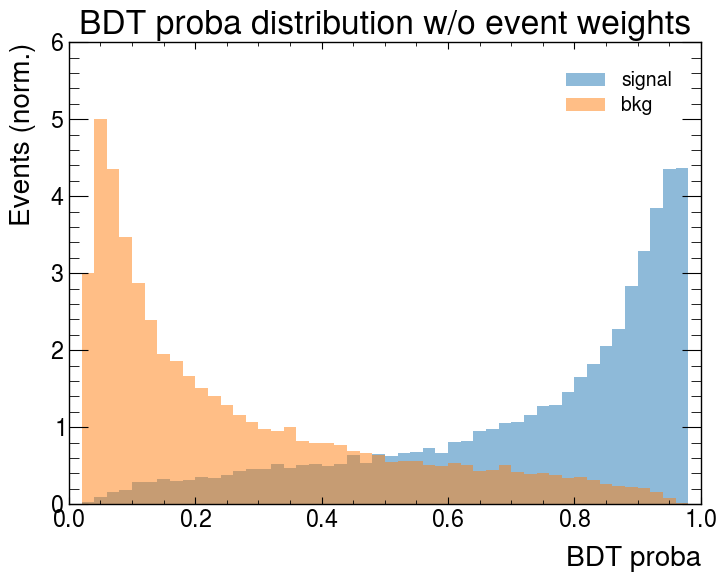

In [198]:
fig, ax = plt.subplots()

ax.hist(y_test_proba[y_test == 1], bins=bin_edges_proba, density=True, alpha=0.5, label="signal")
ax.hist(y_test_proba[y_test == 0], bins=bin_edges_proba, density=True, alpha=0.5, label="bkg")
ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Events (norm.)")
ax.set_title("BDT proba distribution w/o event weights") 
plt.show()

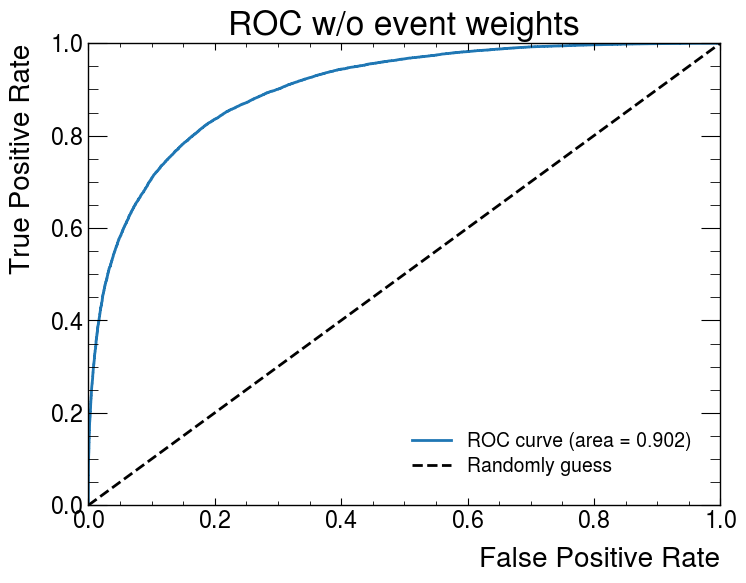

In [49]:
# fpr, tpr, _ = roc_curve(y_test, y_test_proba, sample_weight=X_test['weight'])
fig, ax = plt.subplots()
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

ax.plot(fpr, tpr, label=f"ROC curve (area = {auc(fpr, tpr):.3f})" )
ax.plot([0, 1], [0, 1], 'k--', label='Randomly guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.legend(loc="best")
ax.set_title("ROC w/o event weights") 

plt.show()


/tmp/ipykernel_90679/3604554025.py:10: RuntimeWarning: divide by zero encountered in divide
  metric = S/np.sqrt(B)
/tmp/ipykernel_90679/3604554025.py:10: RuntimeWarning: invalid value encountered in divide
  metric = S/np.sqrt(B)


(0.0, 1.0)

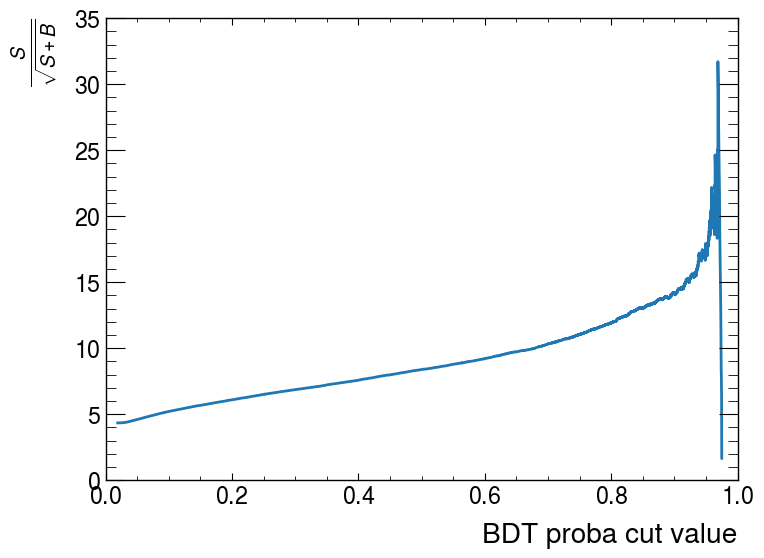

In [73]:
norm_factor_mass_points = df_signal.groupby('file_identifer').sum(numeric_only = True)['weight'] / df_signal['weight'].sum()
norm_factor_m200 = norm_factor_mass_points['signal_m200']

n_sig = X_test.loc[y_test==1 ,'weight'].sum() * norm_factor_m200
n_bkg = X_test.loc[y_test==0 ,'weight'].sum()
# n_sig = len(y_test[y_test==1])
# n_bkg = len(y_test[y_test==0])
S = n_sig*tpr
B = n_bkg*fpr
metric = S/np.sqrt(B)

plt.plot(thresholds, metric)
plt.xlabel('BDT proba cut value')
plt.ylabel('$\\frac{S}{\\sqrt{S+B}}$')
plt.xlim(0, 1.0)


In [76]:
n_sig / np.sqrt(n_bkg)

4.345100581268627

In [78]:
n_sig

26.059132386533893

In [77]:
n_bkg

35.96832687148208

In [80]:
df_signal['bdt_proba'] = bdt.predict_proba(df_signal[features])[:, 1]
df_bkg['bdt_proba'] = bdt.predict_proba(df_bkg[features])[:, 1]

In [85]:
joblib.dump(bdt, "bdt.pkl")

['bdt.pkl']

In [86]:
df_signal_groubpy = df_signal.groupby('file_identifer')

In [89]:
mass_points

array([ 200,  225,  250,  275,  300,  325,  350,  375,  400,  425,  450,
        475,  500,  525,  550,  600,  700,  800,  900, 1000, 1500, 2000,
       3000])

Text(0.5, 1.0, 'BDT proba distribution w/o event weights')

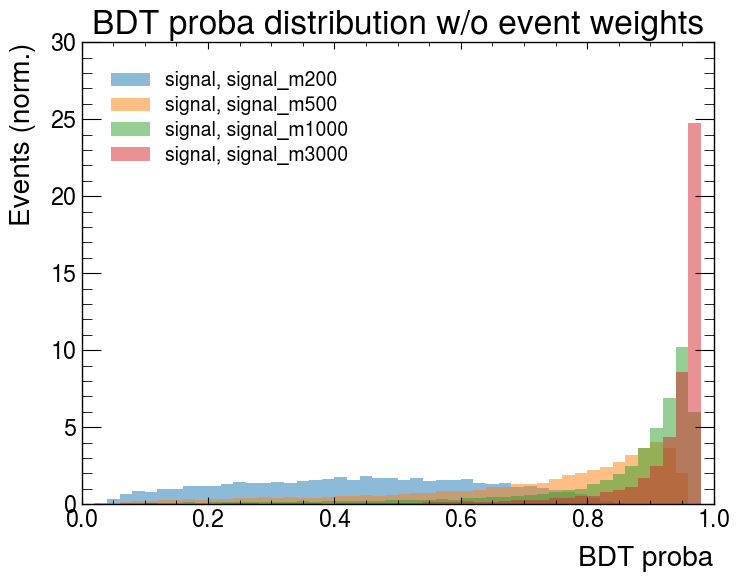

In [119]:
fig, ax = plt.subplots() 
bin_edges_proba = np.linspace(0, 1, 51)
for mass_point in ['signal_m200', 'signal_m500', 'signal_m1000', 'signal_m3000']:
    bdt_proba = df_signal_groubpy.get_group(mass_point)['bdt_proba']
    ax.hist(bdt_proba, bins=bin_edges_proba, density=True, alpha=0.5, label=f"signal, {mass_point}")
ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Events (norm.)")
ax.set_title("BDT proba distribution w/o event weights")

### Significance

In [171]:
df_signal_m200 = df_signal_groubpy.get_group('signal_m200')
combined = pd.concat([df_signal_m200, df_bkg])
fpr, tpr, thresholds = roc_curve(combined['target'], combined['bdt_proba'])

n_sig = df_signal_m200['weight'].sum() 
n_bkg = df_bkg['weight'].sum()

In [172]:
n_sig / np.sqrt(n_sig + n_bkg)

11.474128194984074

/tmp/ipykernel_90679/485563163.py:3: RuntimeWarning: invalid value encountered in divide
  metric = S/np.sqrt(S+B)


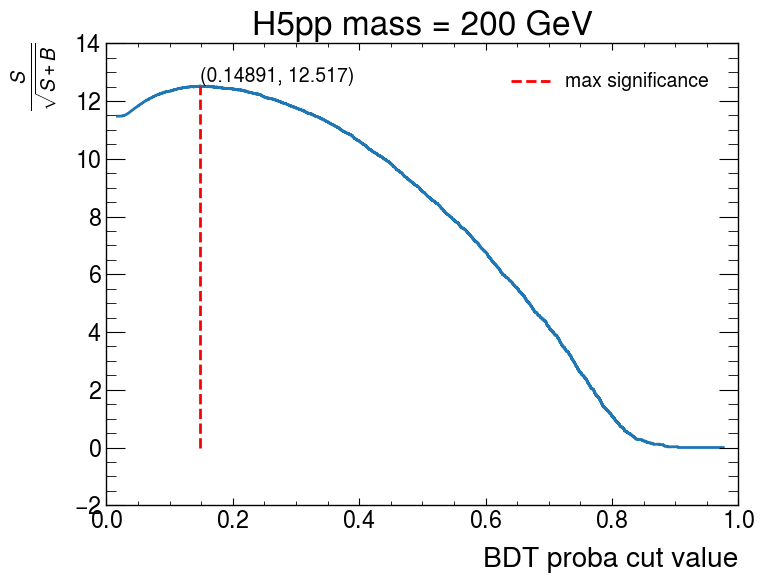

In [183]:
S = n_sig*tpr
B = n_bkg*fpr
metric = S/np.sqrt(S+B)

arg_idx= np.argmax(metric[1:])


plt.plot(thresholds, metric)
plt.xlabel('BDT proba cut value')
plt.ylabel('$\\frac{S}{\\sqrt{S+B}}$')
plt.title("H5pp mass = 200 GeV")
plt.xlim(0, 1.0)
plt.vlines(thresholds[arg_idx], 0, metric[arg_idx+1], color='r', linestyle='--', label=f"max significance")
plt.text(thresholds[arg_idx], metric[arg_idx+1], f"({thresholds[arg_idx]:.5f}, {metric[arg_idx+1]:.3f})", ha='left', va='bottom')
plt.legend()

bdt_proba_cut = thresholds[arg_idx]


In [114]:
metric

array([        nan,  0.        ,  0.        , ..., 11.47444718,
       11.47442785, 11.47412819])

0.14891076906257253

In [107]:
df_signal_m3000 = df_signal_groubpy.get_group('signal_m3000')
combined = pd.concat([df_signal_m3000, df_bkg])
fpr, tpr, thresholds = roc_curve(combined['target'], combined['bdt_proba'])

n_sig = df_signal_m3000['weight'].sum() 
n_bkg = df_bkg['weight'].sum()

In [108]:
n_sig / np.sqrt(n_bkg)

0.01670389197184806

/tmp/ipykernel_90679/1883123053.py:3: RuntimeWarning: invalid value encountered in divide
  metric = S/np.sqrt(S+B)


(0.0, 1.0)

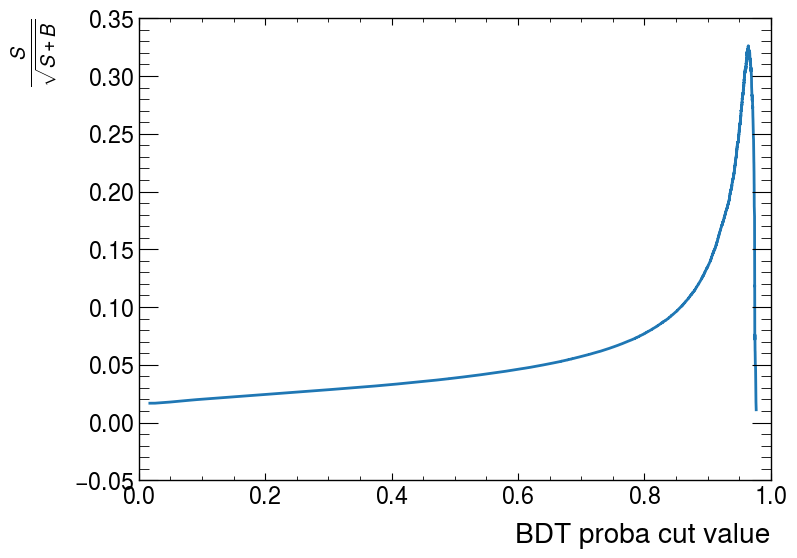

In [109]:
S = n_sig*tpr
B = n_bkg*fpr
metric = S/np.sqrt(S+B)

plt.plot(thresholds, metric)
plt.xlabel('BDT proba cut value')
plt.ylabel('$\\frac{S}{\\sqrt{S+B}}$')
plt.xlim(0, 1.0)

In [95]:
thresholds

array([1.97699846, 0.97699846, 0.97681305, ..., 0.02610867, 0.02606766,
       0.01913508])

In [57]:
tpr

array([0.00000000e+00, 1.00378091e-04, 1.33837454e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [58]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99631388, 0.9963803 ,
       1.        ])

In [55]:
n_bkg

35.96832687148208

In [52]:
tpr

array([0.00000000e+00, 1.00378091e-04, 1.33837454e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [48]:
tpr

array([0.00000000e+00, 1.00378091e-04, 1.33837454e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [47]:
S

array([0.0000e+00, 3.0000e+00, 4.0000e+00, ..., 2.9887e+04, 2.9887e+04,
       2.9887e+04])

In [46]:
n_bkg

30113

## Event weights 

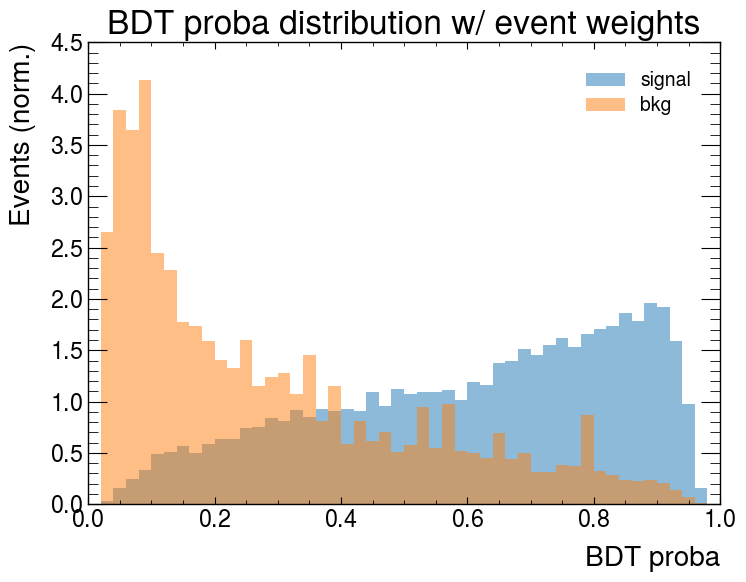

In [200]:
fig, ax = plt.subplots()

ax.hist(y_test_proba[y_test == 1], bins=bin_edges_proba, density=True, weights = X_test.loc[y_test == 1, 'weight'], alpha=0.5, label="signal")
ax.hist(y_test_proba[y_test == 0], bins=bin_edges_proba, density=True, weights = X_test.loc[y_test == 0, 'weight'], alpha=0.5, label="bkg")
ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Events (norm.)")
ax.set_title("BDT proba distribution w/ event weights") 
plt.show()

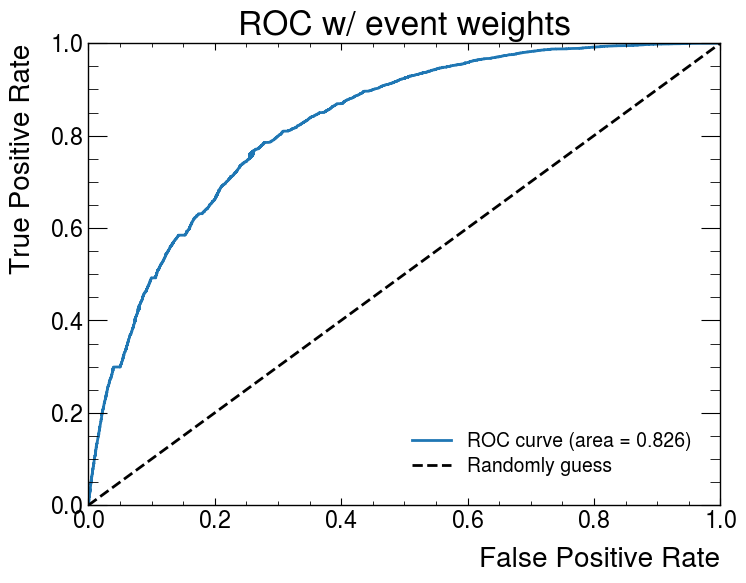

In [25]:
# fpr, tpr, _ = roc_curve(y_test, y_test_proba, sample_weight=X_test['weight'])
fig, ax = plt.subplots()
fpr, tpr, _ = roc_curve(y_test, y_test_proba, sample_weight=X_test['weight'])

# sort the values
idx = np.argsort(fpr)
fpr = fpr[idx]
tpr = tpr[idx]

ax.plot(fpr, tpr, label=f"ROC curve (area = {auc(fpr, tpr):.3f})" )
ax.plot([0, 1], [0, 1], 'k--', label='Randomly guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.legend(loc="best")
ax.set_title("ROC w/ event weights") 

plt.show()


Text(0.5, 1.0, 'BDT proba distribution w/ event weights')

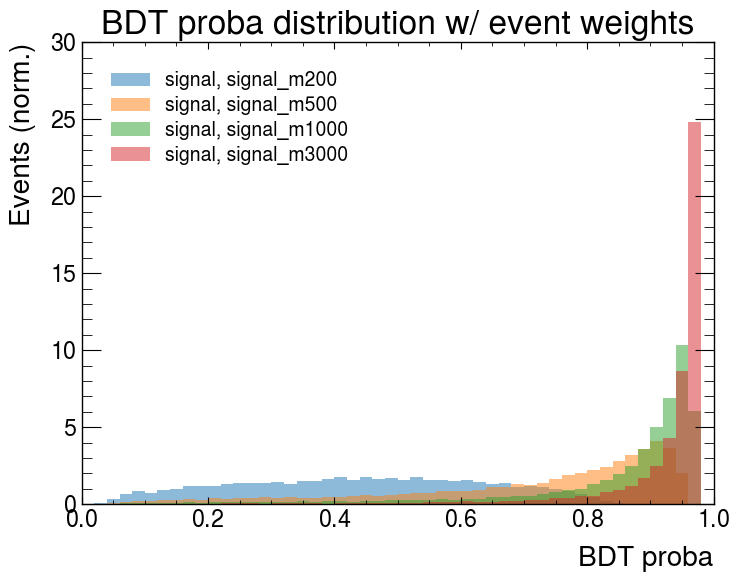

In [118]:
fig, ax = plt.subplots() 
bin_edges_proba = np.linspace(0, 1, 51)
for mass_point in ['signal_m200', 'signal_m500', 'signal_m1000', 'signal_m3000']:
    bdt_proba = df_signal_groubpy.get_group(mass_point)['bdt_proba']
    weights = df_signal_groubpy.get_group(mass_point)['weight']
    ax.hist(bdt_proba, bins=bin_edges_proba, density=True, weights=weights, alpha=0.5, label=f"signal, {mass_point}")
ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Events (norm.)")
ax.set_title("BDT proba distribution w/ event weights")

Text(0.5, 1.0, 'BDT proba distribution w/ event weights')

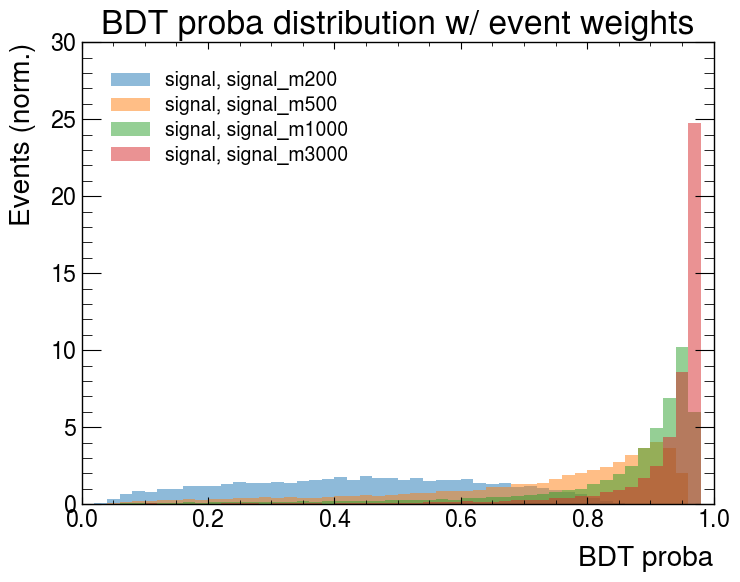

In [120]:
fig, ax = plt.subplots() 
bin_edges_proba = np.linspace(0, 1, 51)
for mass_point in ['signal_m200', 'signal_m500', 'signal_m1000', 'signal_m3000']:
    bdt_proba = df_signal_groubpy.get_group(mass_point)['bdt_proba']
    weights = df_signal_groubpy.get_group(mass_point)['weight']
    ax.hist(bdt_proba, bins=bin_edges_proba, density=True, alpha=0.5, label=f"signal, {mass_point}")
ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Events (norm.)")
ax.set_title("BDT proba distribution w/ event weights")

Text(0.5, 1.0, 'BDT proba distribution w/o event weights')

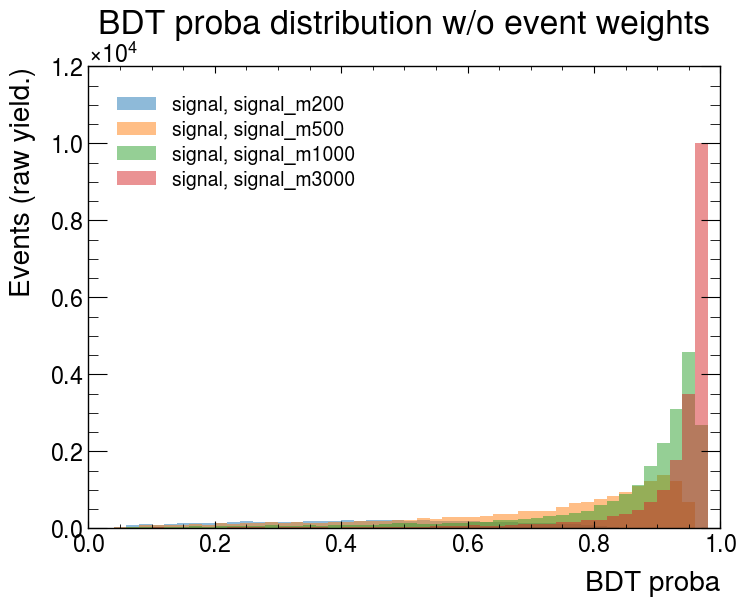

In [124]:
fig, ax = plt.subplots() 
bin_edges_proba = np.linspace(0, 1, 51)
for mass_point in ['signal_m200', 'signal_m500', 'signal_m1000', 'signal_m3000']:
    bdt_proba = df_signal_groubpy.get_group(mass_point)['bdt_proba']
    weights = df_signal_groubpy.get_group(mass_point)['weight']
    ax.hist(bdt_proba, bins=bin_edges_proba, alpha=0.5, label=f"signal, {mass_point}")
ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Events (raw yield.)")
ax.set_title("BDT proba distribution w/o event weights")

In [138]:
pd.DataFrame([df_signal_groubpy.sum(numeric_only=True)['weight'], df_signal_groubpy.count()['weight']], index=['weighted yield', 'raw yield']).T

,weighted yield,raw yield
file_identifer,,
signal_m1000,11.107396,22392.0
signal_m1500,3.076995,22993.0
signal_m200,316.204417,6125.0
signal_m2000,0.909824,22257.0
signal_m225,348.174002,7333.0
signal_m250,310.083783,8502.0
signal_m275,326.299250,9673.0
signal_m300,290.561009,10613.0
signal_m3000,0.351672,20217.0


file_identifer
signal_m1000    22392
signal_m1500    22993
signal_m200      6125
signal_m2000    22257
signal_m225      7333
signal_m250      8502
signal_m275      9673
signal_m300     10613
signal_m3000    20217
signal_m325     11935
signal_m350     12689
signal_m375     13443
signal_m400     14351
signal_m425     15114
signal_m450     15733
signal_m475     16214
signal_m500     17015
signal_m525     17451
signal_m550     17920
signal_m600     18829
signal_m700     20213
signal_m800     21314
signal_m900     21816
Name: weight, dtype: int64

In [130]:
len(df_signal_groubpy.get_group('signal_m200')['weight'])

6125

In [127]:
weights.sum()

0.3516718065572718

In [125]:
bdt_proba

343925    0.955026
343926    0.974373
343927    0.966462
343928    0.893186
343929    0.894509
            ...   
364137    0.969825
364138    0.974582
364139    0.974748
364140    0.899697
364141    0.964041
Name: bdt_proba, Length: 20217, dtype: float64

Text(0.5, 1.0, 'BDT proba distribution w/ event weights')

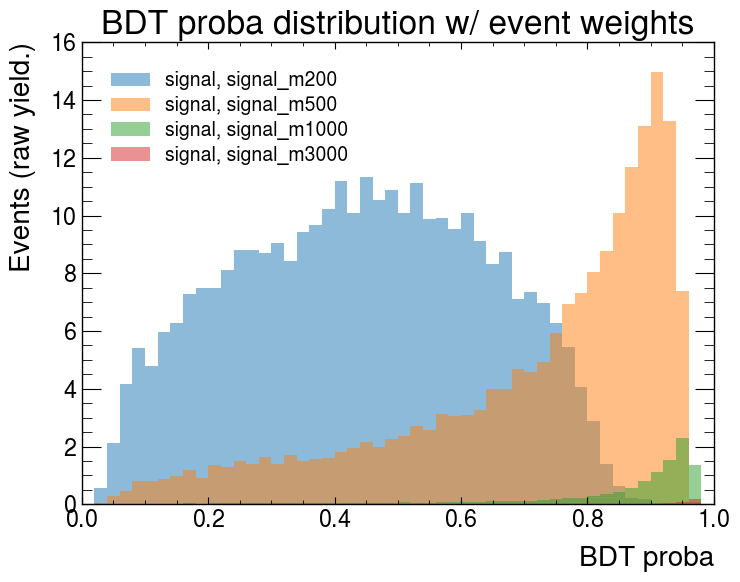

In [123]:
fig, ax = plt.subplots() 
bin_edges_proba = np.linspace(0, 1, 51)
for mass_point in ['signal_m200', 'signal_m500', 'signal_m1000', 'signal_m3000']:
    bdt_proba = df_signal_groubpy.get_group(mass_point)['bdt_proba']
    weights = df_signal_groubpy.get_group(mass_point)['weight']
    ax.hist(bdt_proba, bins=bin_edges_proba, weights=weights, alpha=0.5, label=f"signal, {mass_point}")
ax.legend()
ax.set_xlabel("BDT proba")
ax.set_ylabel("Events (raw yield.)")
ax.set_title("BDT proba distribution w/ event weights")

In [26]:
pd.DataFrame(bdt.feature_importances_, index=features, columns=['importance']).sort_values('importance', ascending=False)

,importance
dyjj,0.538722
lep1_pt,0.117126
jet1_pt,0.108971
lep0_pt,0.105408
jet0_pt,0.074978
met,0.039700
nJets,0.007001
lep0_eta,0.004201
lep1_eta,0.002472
lep0_e,0.000467


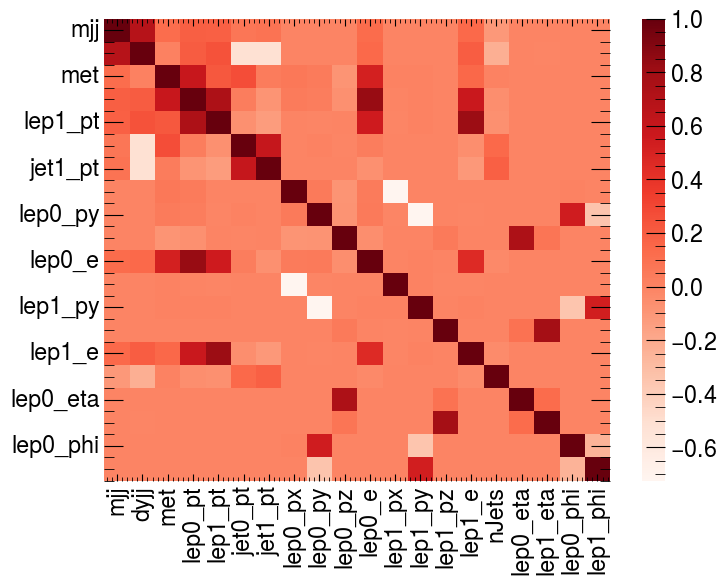

In [58]:
import seaborn as sns
cor = X.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
# plt.savefig("./plots/corr")
plt.show()

# Significance Benchmark 

In [143]:
import re
matched = re.findall(r"signal_m(\d+)", "signal_m200")
if matched:
    print(matched[0])

200


In [163]:
B = df_bkg['weight'].sum()
significance_benchmark = {}
for key, value in df_signal_groubpy:
    matched = re.findall(r"signal_m(\d+)", key)
    if matched: 
        mass_point = int(matched[0])

    S = value['weight'].sum()
    significance_benchmark[mass_point] = S/np.sqrt(S+B)
    

In [164]:
significance_benchmark

{1000: 0.5210960969773489,
 1500: 0.1456480288893087,
 200: 11.474128194984074,
 2000: 0.04317101293992477,
 225: 12.376397420666228,
 250: 11.297646342319355,
 275: 11.762522115174345,
 300: 10.726250537912989,
 3000: 0.016697269393063804,
 325: 11.123146676437702,
 350: 9.953478092723062,
 375: 9.805178715048292,
 400: 9.028725299977314,
 425: 8.878529031984378,
 450: 8.089823805818613,
 475: 7.913333703897939,
 500: 7.258574131870395,
 525: 6.872654671044458,
 550: 6.400280130698121,
 600: 5.653541575662379,
 700: 4.360664803137531,
 800: 3.386307533362516,
 900: 0.6778741595219573}

Text(1, 0, 'H5pp mass point')

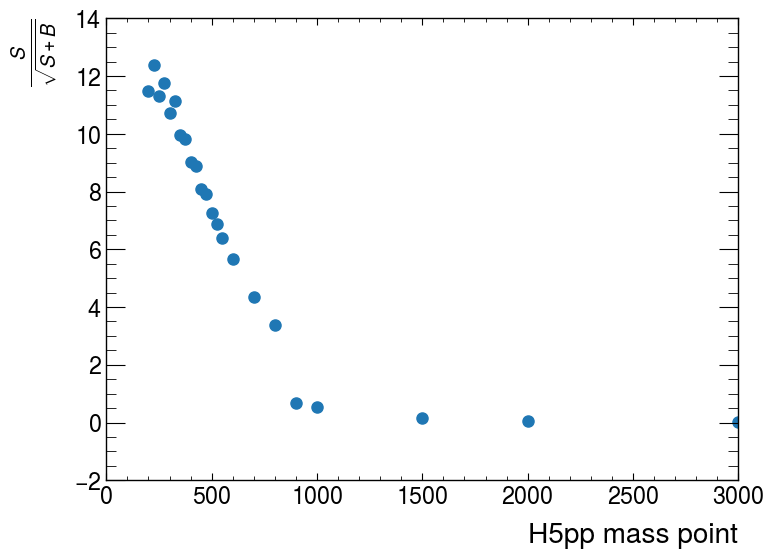

In [184]:
B = df_bkg.loc[df_bkg['bdt_proba'] > bdt_proba_cut, 'weight'].sum()

significance_improved = {}
for key, value in df_signal_groubpy:
    matched = re.findall(r"signal_m(\d+)", key)
    if matched: 
        mass_point = int(matched[0])

    S = value.loc[value['bdt_proba'] > bdt_proba_cut, 'weight'].sum()
    significance_improved[mass_point] = S/np.sqrt(S+B)
    

In [185]:
significance_improved

{1000: 0.6598417841596059,
 1500: 0.18599265132882387,
 200: 12.299623984130703,
 2000: 0.055294158923674,
 225: 13.32669212318879,
 250: 12.332119131914743,
 275: 12.85565612627842,
 300: 11.853198431779678,
 3000: 0.021407717017825553,
 325: 12.300058379523268,
 350: 11.142843968501356,
 375: 11.026236100826253,
 400: 10.219212710944593,
 425: 10.096292421805757,
 450: 9.270618881097743,
 475: 9.111694641740147,
 500: 8.422723628356247,
 525: 7.98906569129273,
 550: 7.496955918074406,
 600: 6.680250637252288,
 700: 5.2353946523330634,
 800: 4.119116238671564,
 900: 0.855181091133691}

Text(0.5, 1.0, 'Significance vs H5pp mass point')

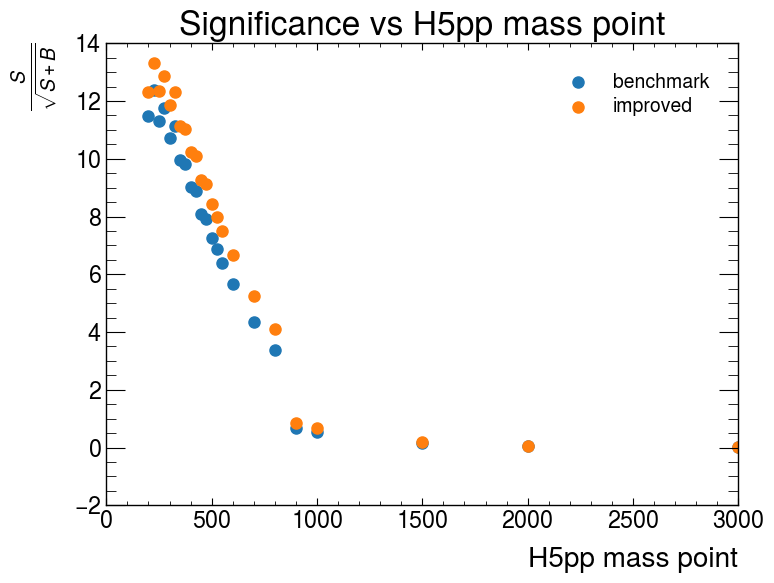

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
plt.scatter(significance_benchmark.keys(), significance_benchmark.values(), label="benchmark")
plt.scatter(significance_improved.keys(), significance_improved.values(), label="improved")
plt.ylabel('$\\frac{S}{\\sqrt{S+B}}$')
plt.xlabel('H5pp mass point')
plt.legend()
plt.title("Significance vs H5pp mass point")